# Heam Trajectory

In [8]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
col_pal = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"
]

In [1]:
run_name = 'FLIV_Heam_trajectory_with_290921'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/matched_liver_data/A1.210312_fliv_matched_ys_meta_updated.h5ad'

In [2]:
save_loc+run_name+'.h5ad'

'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/FLIV_Heam_trajectory_with_290921.h5ad'

In [11]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids',
       'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender',
       'AnnatomicalPart', 'fullmeta', 'scrublet_score',
       'scrublet_cluster_score', 'bh_pval', 'short_code', 'oldanno',
       'subcluster_annotation', 'pred', 'annotated_clusters',
       'annotated_clusters_reduced', 'cell.labels', 'cell.labels_old',
       'cell_labels', 'broad_cell_labels'],
      dtype='object')

In [12]:
list(adata.obs['cell_labels'].unique())

['MPP',
 'Kupffer_cell_1',
 'Kupffer_cell_2',
 'Hepatocyte',
 'Endothelium',
 'Early_Erythroid',
 'MEMP',
 'MLP',
 'MK',
 'Erythroid',
 'DC3',
 'DC2',
 'Monocyte',
 'HSC',
 'Promyelocyte',
 'Mast_cell',
 'DC1',
 'CMP',
 'Pre_pro_B_progenitor',
 'Embryonic_Erythroid',
 'MOP',
 'Eo_Basophil',
 'Promonocyte',
 'ELP',
 'Pre_DC2',
 'pDC',
 'NK',
 'MPP2',
 'ETP',
 'LMPP',
 'Pre_B',
 'Fibroblast',
 'ILC_precursor',
 'Immature_B_cell',
 'Pre_pDC',
 'Pro_B_progenitor',
 'Pre_ILC_precursor']

In [17]:
adata = adata[adata.obs['cell_labels'].isin([
 'MPP',
 'Kupffer_cell_1',
 'Kupffer_cell_2',
 'Early_Erythroid',
 'MEMP',
 'MLP',
 'MK',
 'Erythroid',
 'DC3',
 'DC2',
 'Monocyte',
 'HSC',
 'Promyelocyte',
 'Mast_cell',
 'DC1',
 'CMP',
 'Pre_pro_B_progenitor',
 'Embryonic_Erythroid',
 'MOP',
 'Eo_Basophil',
 'Promonocyte',
 'ELP',
 'Pre_DC2',
 'pDC',
 'NK',
 'MPP2',
 'ETP',
 'LMPP',
 'Pre_B',
 'ILC_precursor',
 'Immature_B_cell',
 'Pre_pDC',
 'Pro_B_progenitor',
 'Pre_ILC_precursor'])]

In [18]:
list(adata.obs['cell_labels'].unique())

['MPP',
 'Kupffer_cell_1',
 'Kupffer_cell_2',
 'Early_Erythroid',
 'MEMP',
 'MLP',
 'MK',
 'Erythroid',
 'DC3',
 'DC2',
 'Monocyte',
 'HSC',
 'Promyelocyte',
 'Mast_cell',
 'DC1',
 'CMP',
 'Pre_pro_B_progenitor',
 'Embryonic_Erythroid',
 'MOP',
 'Eo_Basophil',
 'Promonocyte',
 'ELP',
 'Pre_DC2',
 'pDC',
 'NK',
 'MPP2',
 'ETP',
 'LMPP',
 'Pre_B',
 'Fibroblast',
 'ILC_precursor',
 'Immature_B_cell',
 'Pre_pDC',
 'Pro_B_progenitor',
 'Pre_ILC_precursor']

In [19]:
adata.write(save_loc+run_name+'.h5ad')

In [20]:
adata.obs

n_genes  n_counts orig_ident  \
index                                                                           
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT     4489   19142.0        F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC     1635    4586.0        F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC     2089    7673.0        F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG     3514   14133.0        F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT     2311    6383.0        F61   
...                                                  ...       ...        ...   
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG     1583    8796.0        F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA     3207   13291.0        F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG     4917   32953.0        F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC     5988   59216.0        F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAGTTACCGAT     4397   30561.0        F32   

                                                 percent_mito fetal_ids  \
index                                                                     
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT      0.041741       F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC      0.071304       F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC      0.035579       F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG      0.088516       F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT      0.064703       F61   
...                                                       ...       ...   
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG      0.015689       F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA      0.014747       F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG      0.035930       F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC      0.041577       F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAGTTACCGAT      0.028369       F32   

                                                sort_ids tissue  \
index                                                             
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT    CD45+  Liver   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC    CD45+  Liver   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC    CD45+  Liver   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG    CD45+  Liver   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT    CD45+  Liver   
...                                                  ...    ...   
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG    CD45-  Liver   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA    CD45-  Liver   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG    CD45-  Liver   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC    CD45-  Liver   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAGTTACCGAT    CD45-  Liver   

                                                          lanes stages  \
index                                                                    
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT  FCAImmP7862084    F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC  FCAImmP7862084    F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC  FCAImmP7862084    F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG  FCAImmP7862084    F61   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT  FCAImmP7862084    F61   
...                                                         ...    ...   
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG  FCAImmP7316895    F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA  FCAImmP7316895    F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG  FCAImmP7316895    F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC  FCAImmP7316895    F32   
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAGTTACCGAT  FCAImmP7316895    F32   

                                                sample_type  ...  \
index                                                        ...   
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT 

# Update from cellxgene

In [21]:
#new_annotations = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/050821_YS_updates/progen_fraction/issac-cell-labels-UIMBBYYD.csv',
#                         comment='#',
#                         dtype='category',
#                         index_col=0)
#adata.obs = adata.obs.join(new_annotations)

In [22]:
#adata.obs['cell.labels_back_090921'] = adata.obs['cell.labels'][:]
#adata.obs['cell.labels'] = adata.obs['updates_090921']

In [23]:
#adata.obs['cell.labels_restricted_back_090921'] =  adata.obs['cell.labels_restricted'].copy()

In [24]:
#list(adata.obs['cell.labels'].unique())

In [25]:
#adata.obs = adata.obs.drop(['progen_fraction_ys_090821_leiden_progen_150',
#       'progen_fraction_ys_090821_leiden_progen_150_reassigned',
#       'progen_fraction_ys_120821_leiden_progen_150','cell.labels_15082 1_leiden_assigned1_leiden_assig','cell.labels_140821_leiden_assigned',
#       'cell.labels_15082 1_leiden_assigned1_leiden_assig','updates_090921'],axis=1)

In [26]:
#adata.obs.columns

# preprocess

In [27]:
# Only consider intersecting genes for normalisation etc
#remove_genes = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/data_integration_070721/keep_intersecting_genes.csv',index_col=0)
#keep_genes = list(remove_genes['0'])
#adata = adata[:, adata.var.index.isin(keep_genes)]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:39)
Commencing harmony


2021-09-29 16:53:01,117 - harmonypy - INFO - Iteration 1 of 10
2021-09-29 16:54:23,801 - harmonypy - INFO - Iteration 2 of 10
2021-09-29 16:55:44,104 - harmonypy - INFO - Iteration 3 of 10
2021-09-29 16:57:04,515 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)


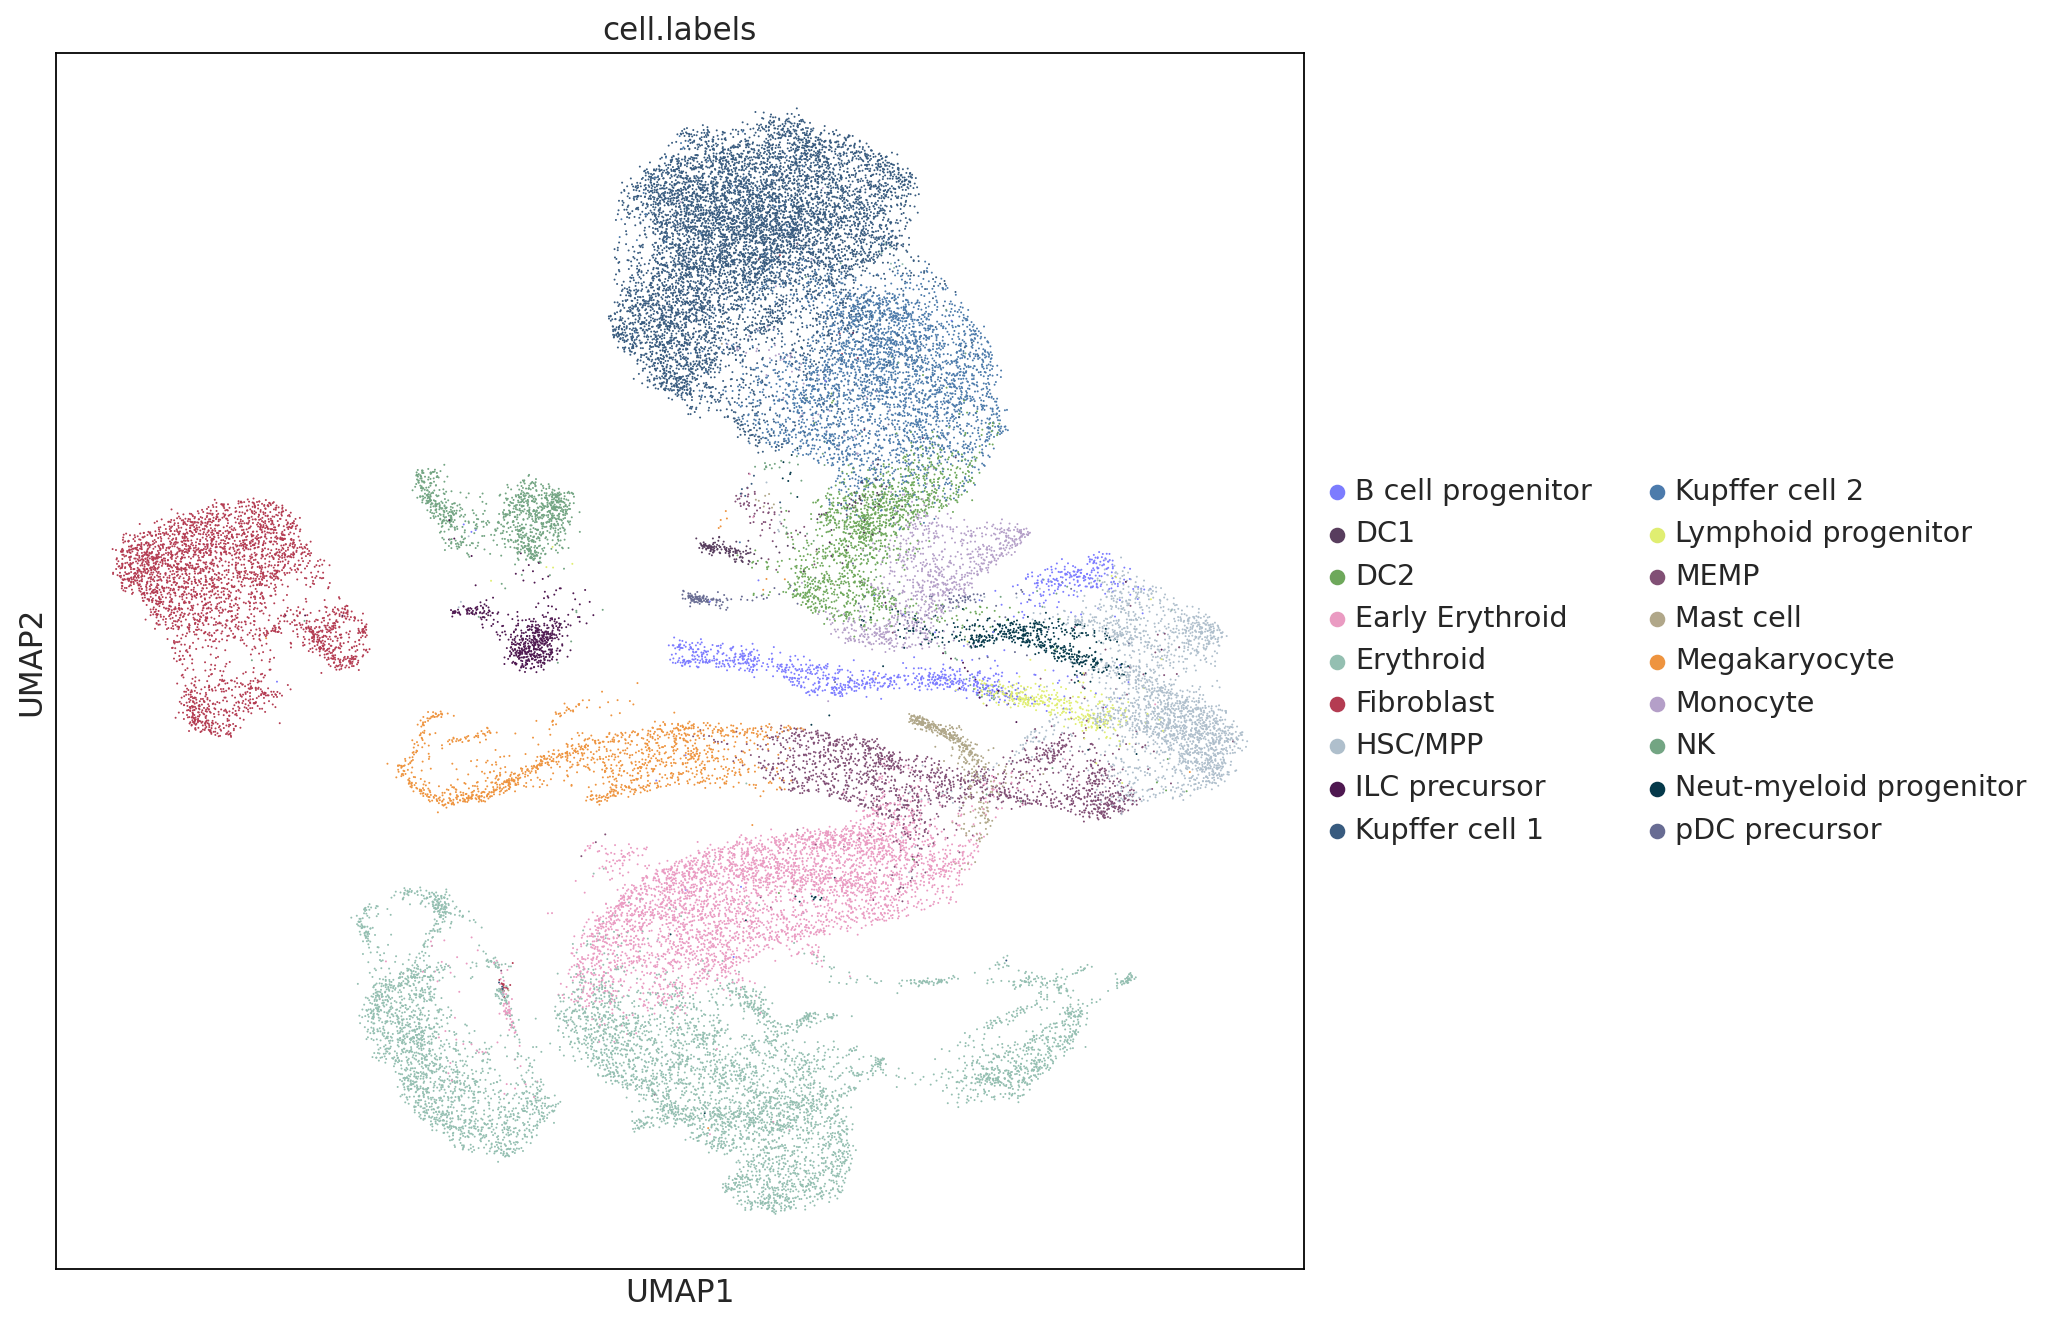

In [29]:

batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ['fetal_ids'] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = batch
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    sc.tl.umap(adata_hm)
    adata = adata_hm[:]
    del adata_hm

sc.pl.umap(adata,color = 'cell.labels')

In [30]:
sc.tl.draw_graph(adata, layout='fa')

drawing single-cell graph using layout 'fa'


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:07:29)


In [57]:
#adata = adata[~adata.obs['cell_labels'].isin(['Fibroblast'])]

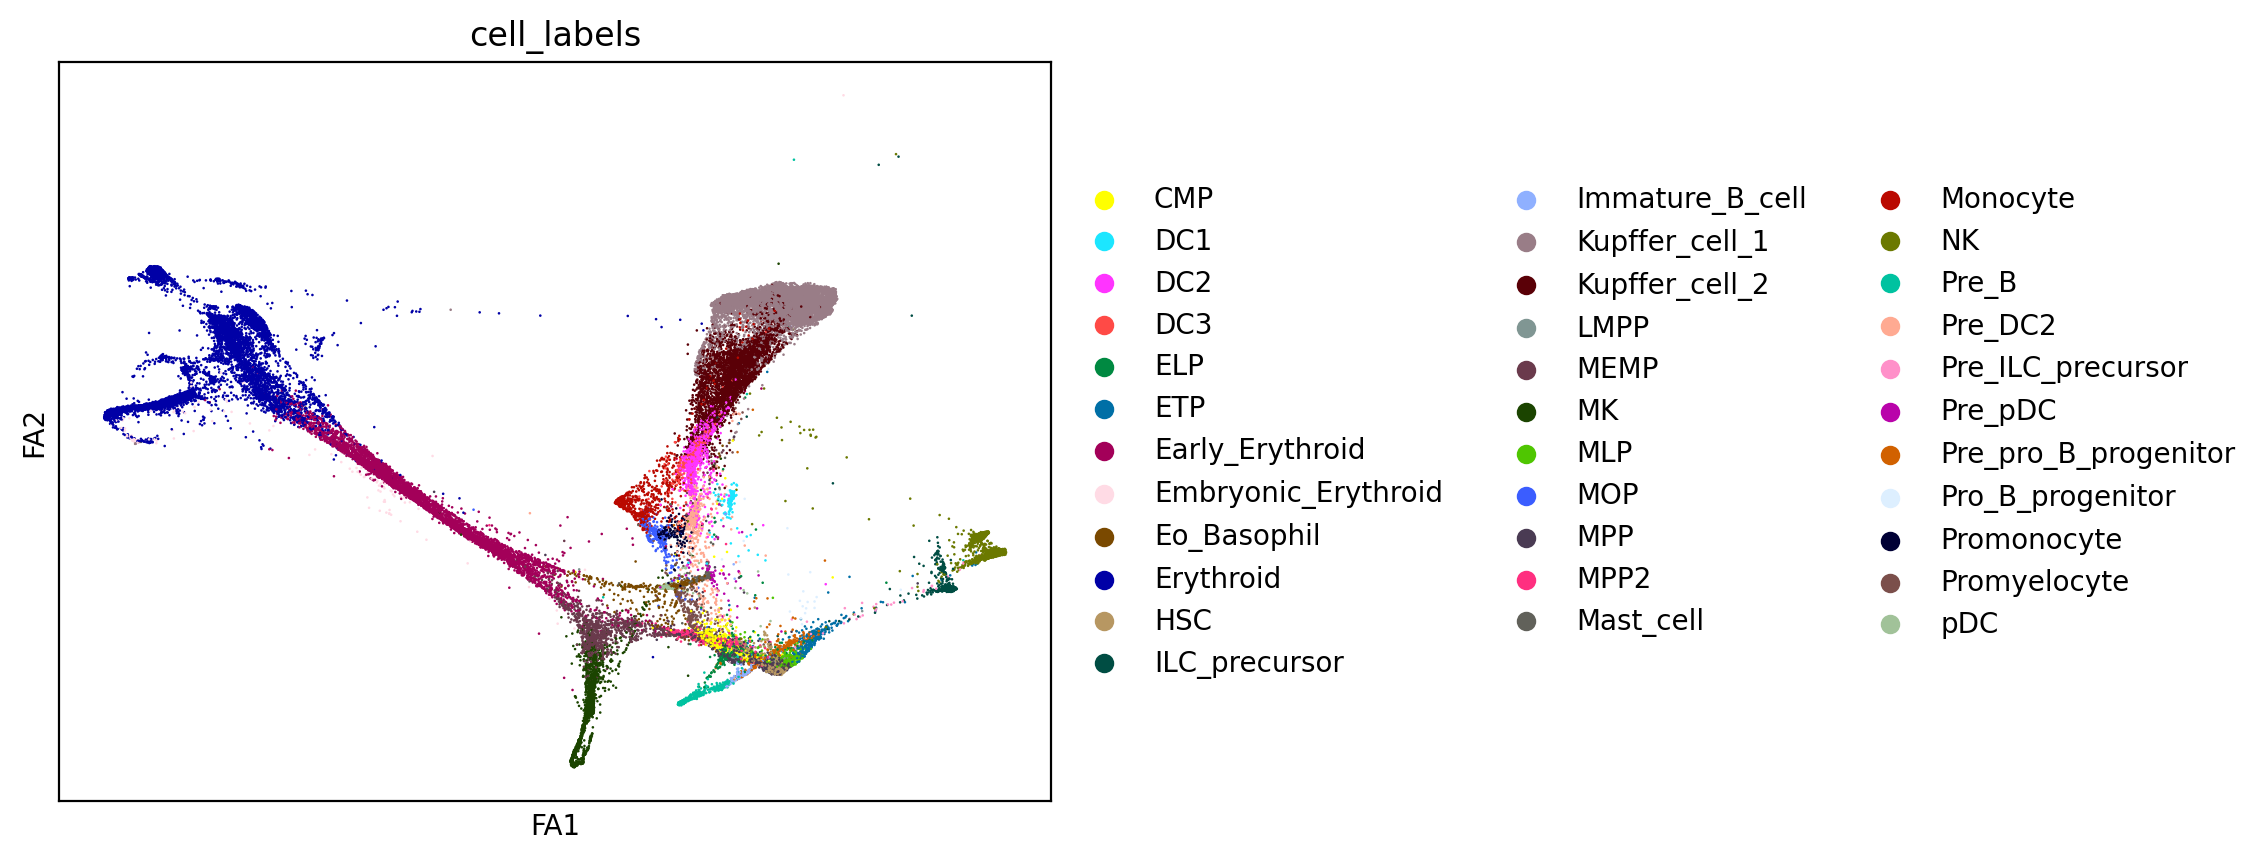

In [58]:
sc.pl.draw_graph(adata, color = 'cell_labels')

In [59]:
adata.write(save_loc+run_name+'.h5ad')

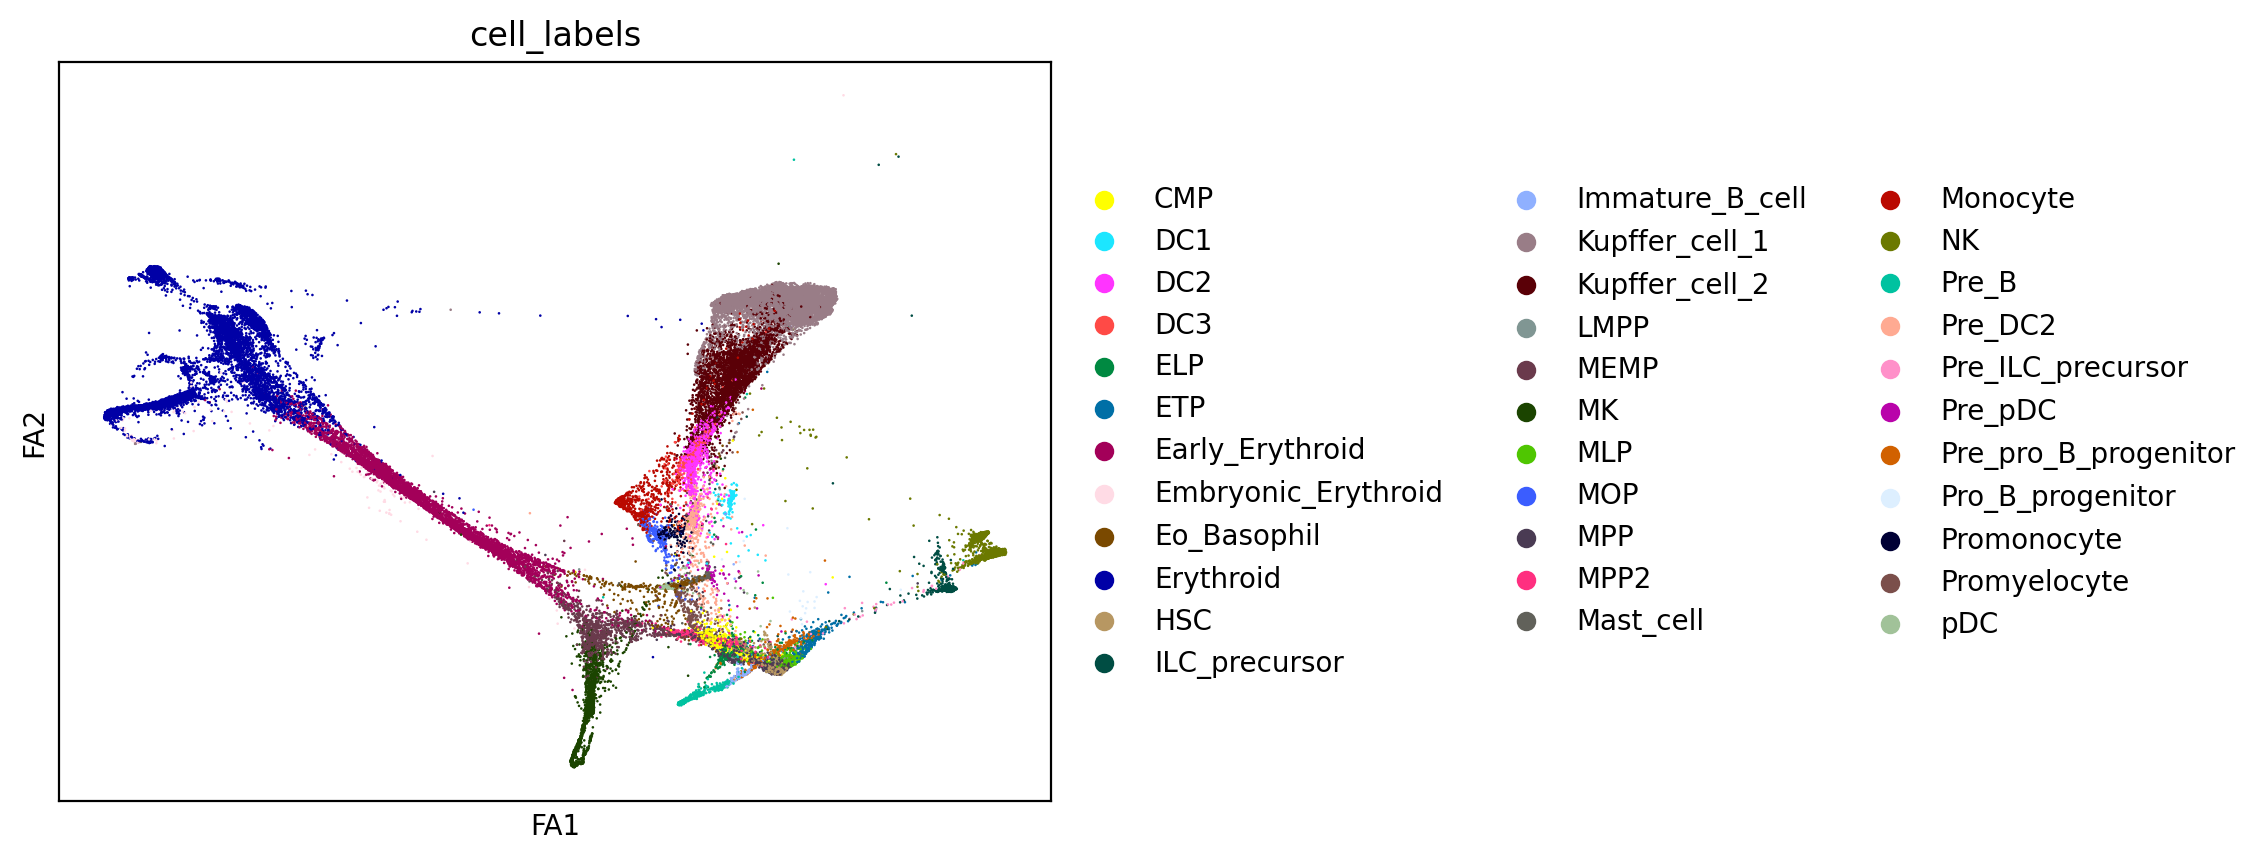

In [60]:
sc.pl.draw_graph(adata, color = 'cell_labels')

In [61]:
fliv = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/fliv_pal.csv")

In [62]:
## Vars
adata_var = "cell_labels"
col_pal = fliv

In [63]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var]
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

Trying to set attribute `.obs` of view, copying.


34 {'PRE_DC2', 'MEMP', 'ETP', 'ILC_PRECURSOR', 'PRE_ILC_PRECURSOR', 'ERYTHROID', 'MPP2', 'MK', 'MPP', 'HSC', 'PDC', 'EARLY_ERYTHROID', 'PRE_B', 'PRO_B_PROGENITOR', 'DC1', 'PRE_PDC', 'PRE_PRO_B_PROGENITOR', 'MOP', 'EO_BASOPHIL', 'PROMONOCYTE', 'DC2', 'KUPFFER_CELL_1', 'MONOCYTE', 'MAST_CELL', 'DC3', 'CMP', 'KUPFFER_CELL_2', 'NK', 'PROMYELOCYTE', 'EMBRYONIC_ERYTHROID', 'ELP', 'LMPP', 'MLP', 'IMMATURE_B_CELL'}
non_intersect {'HEPATOCYTE', 'FIBROBLAST', 'ENDOTHELIUM'}


In [64]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

non_intersect {'HEPATOCYTE', 'FIBROBLAST', 'ENDOTHELIUM'}


In [65]:
adata.obs['var']

index
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT                MPP
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC     KUPFFER_CELL_1
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC     KUPFFER_CELL_2
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG     KUPFFER_CELL_1
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT     KUPFFER_CELL_1
                                                        ...       
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG          ERYTHROID
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA    EARLY_ERYTHROID
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG    EARLY_ERYTHROID
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC    EARLY_ERYTHROID
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAGTTACCGAT    EARLY_ERYTHROID
Name: var, Length: 34679, dtype: object

# Minor Corrections

In [66]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

non_intersect {'HEPATOCYTE', 'FIBROBLAST', 'ENDOTHELIUM'}


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var' as categorical


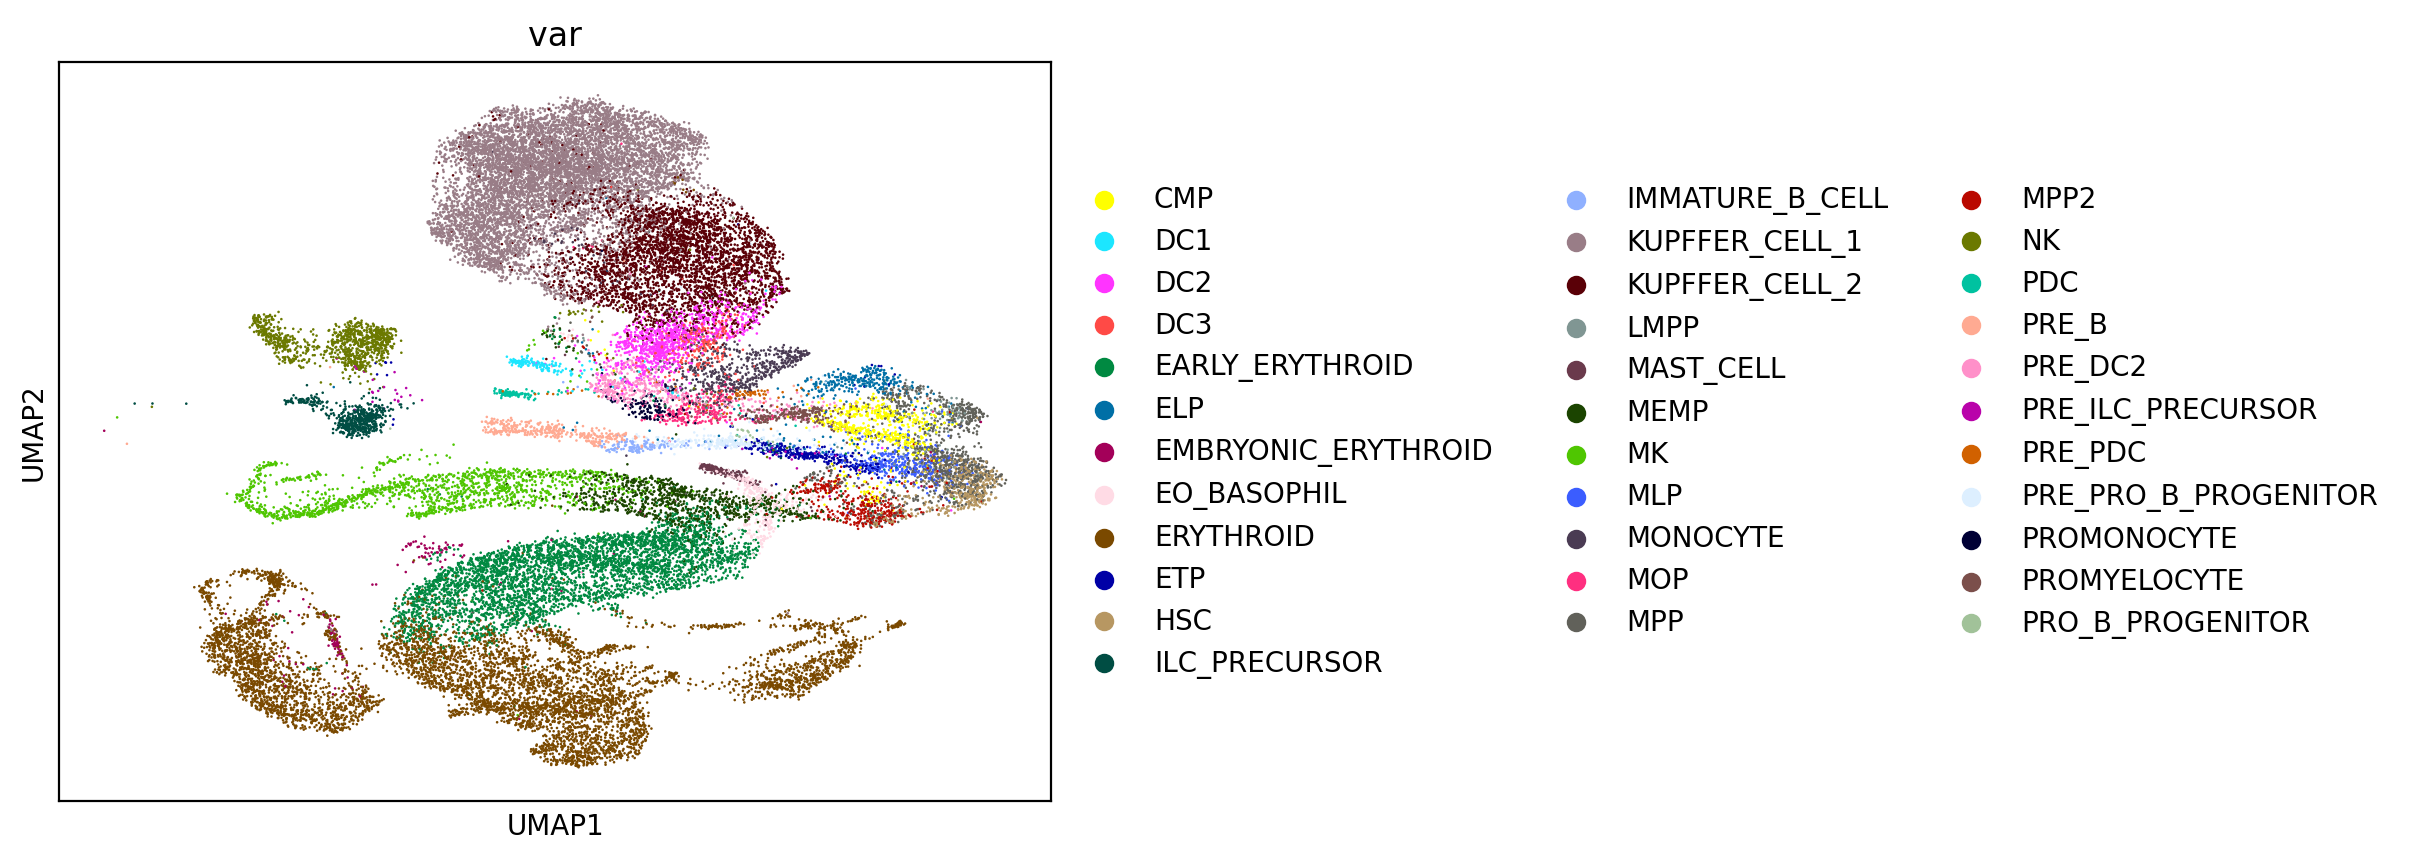

In [67]:
sc.pl.umap(adata, color = "var")

In [68]:
list(adata.obs['var']).sort()

# Create mappable field

In [69]:
cells = list(adata.obs['var'].unique())
cells.sort()
col = list(range(0,len(cells)))
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

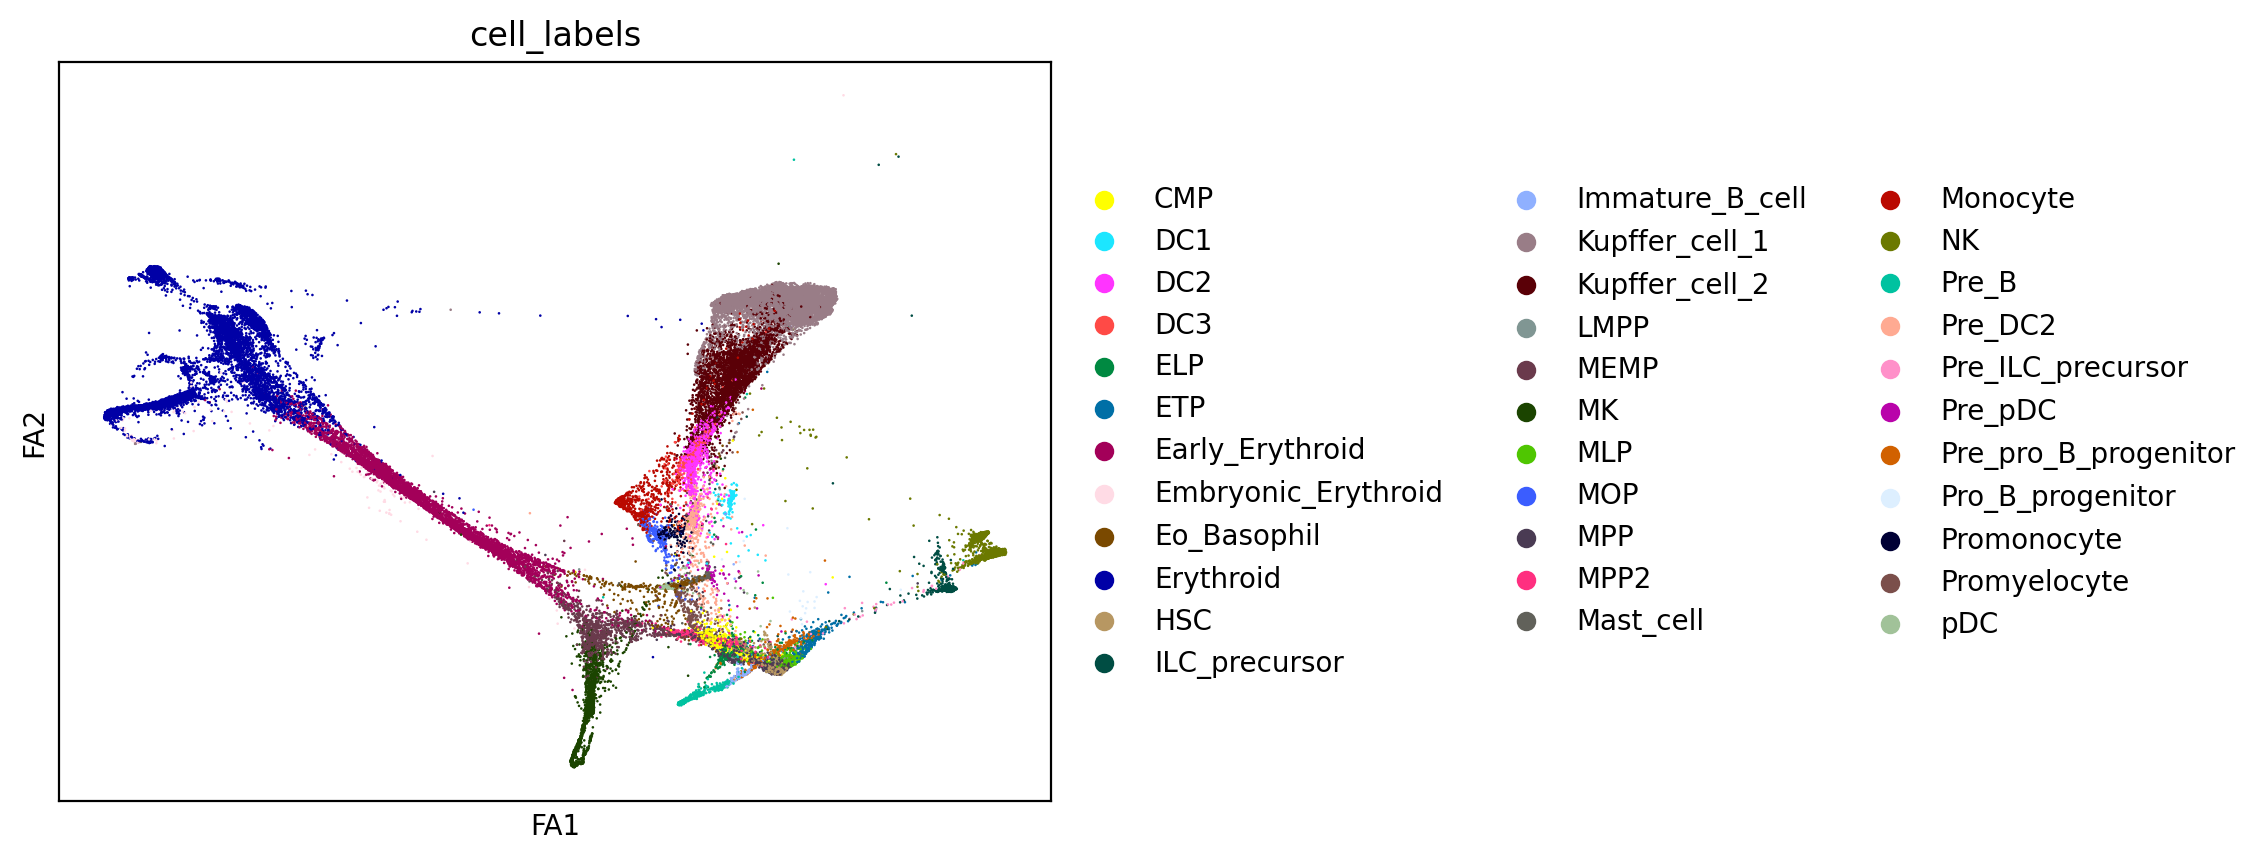

In [70]:
sc.pl.draw_graph(adata, color = 'cell_labels')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'num' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var_num' as categorical


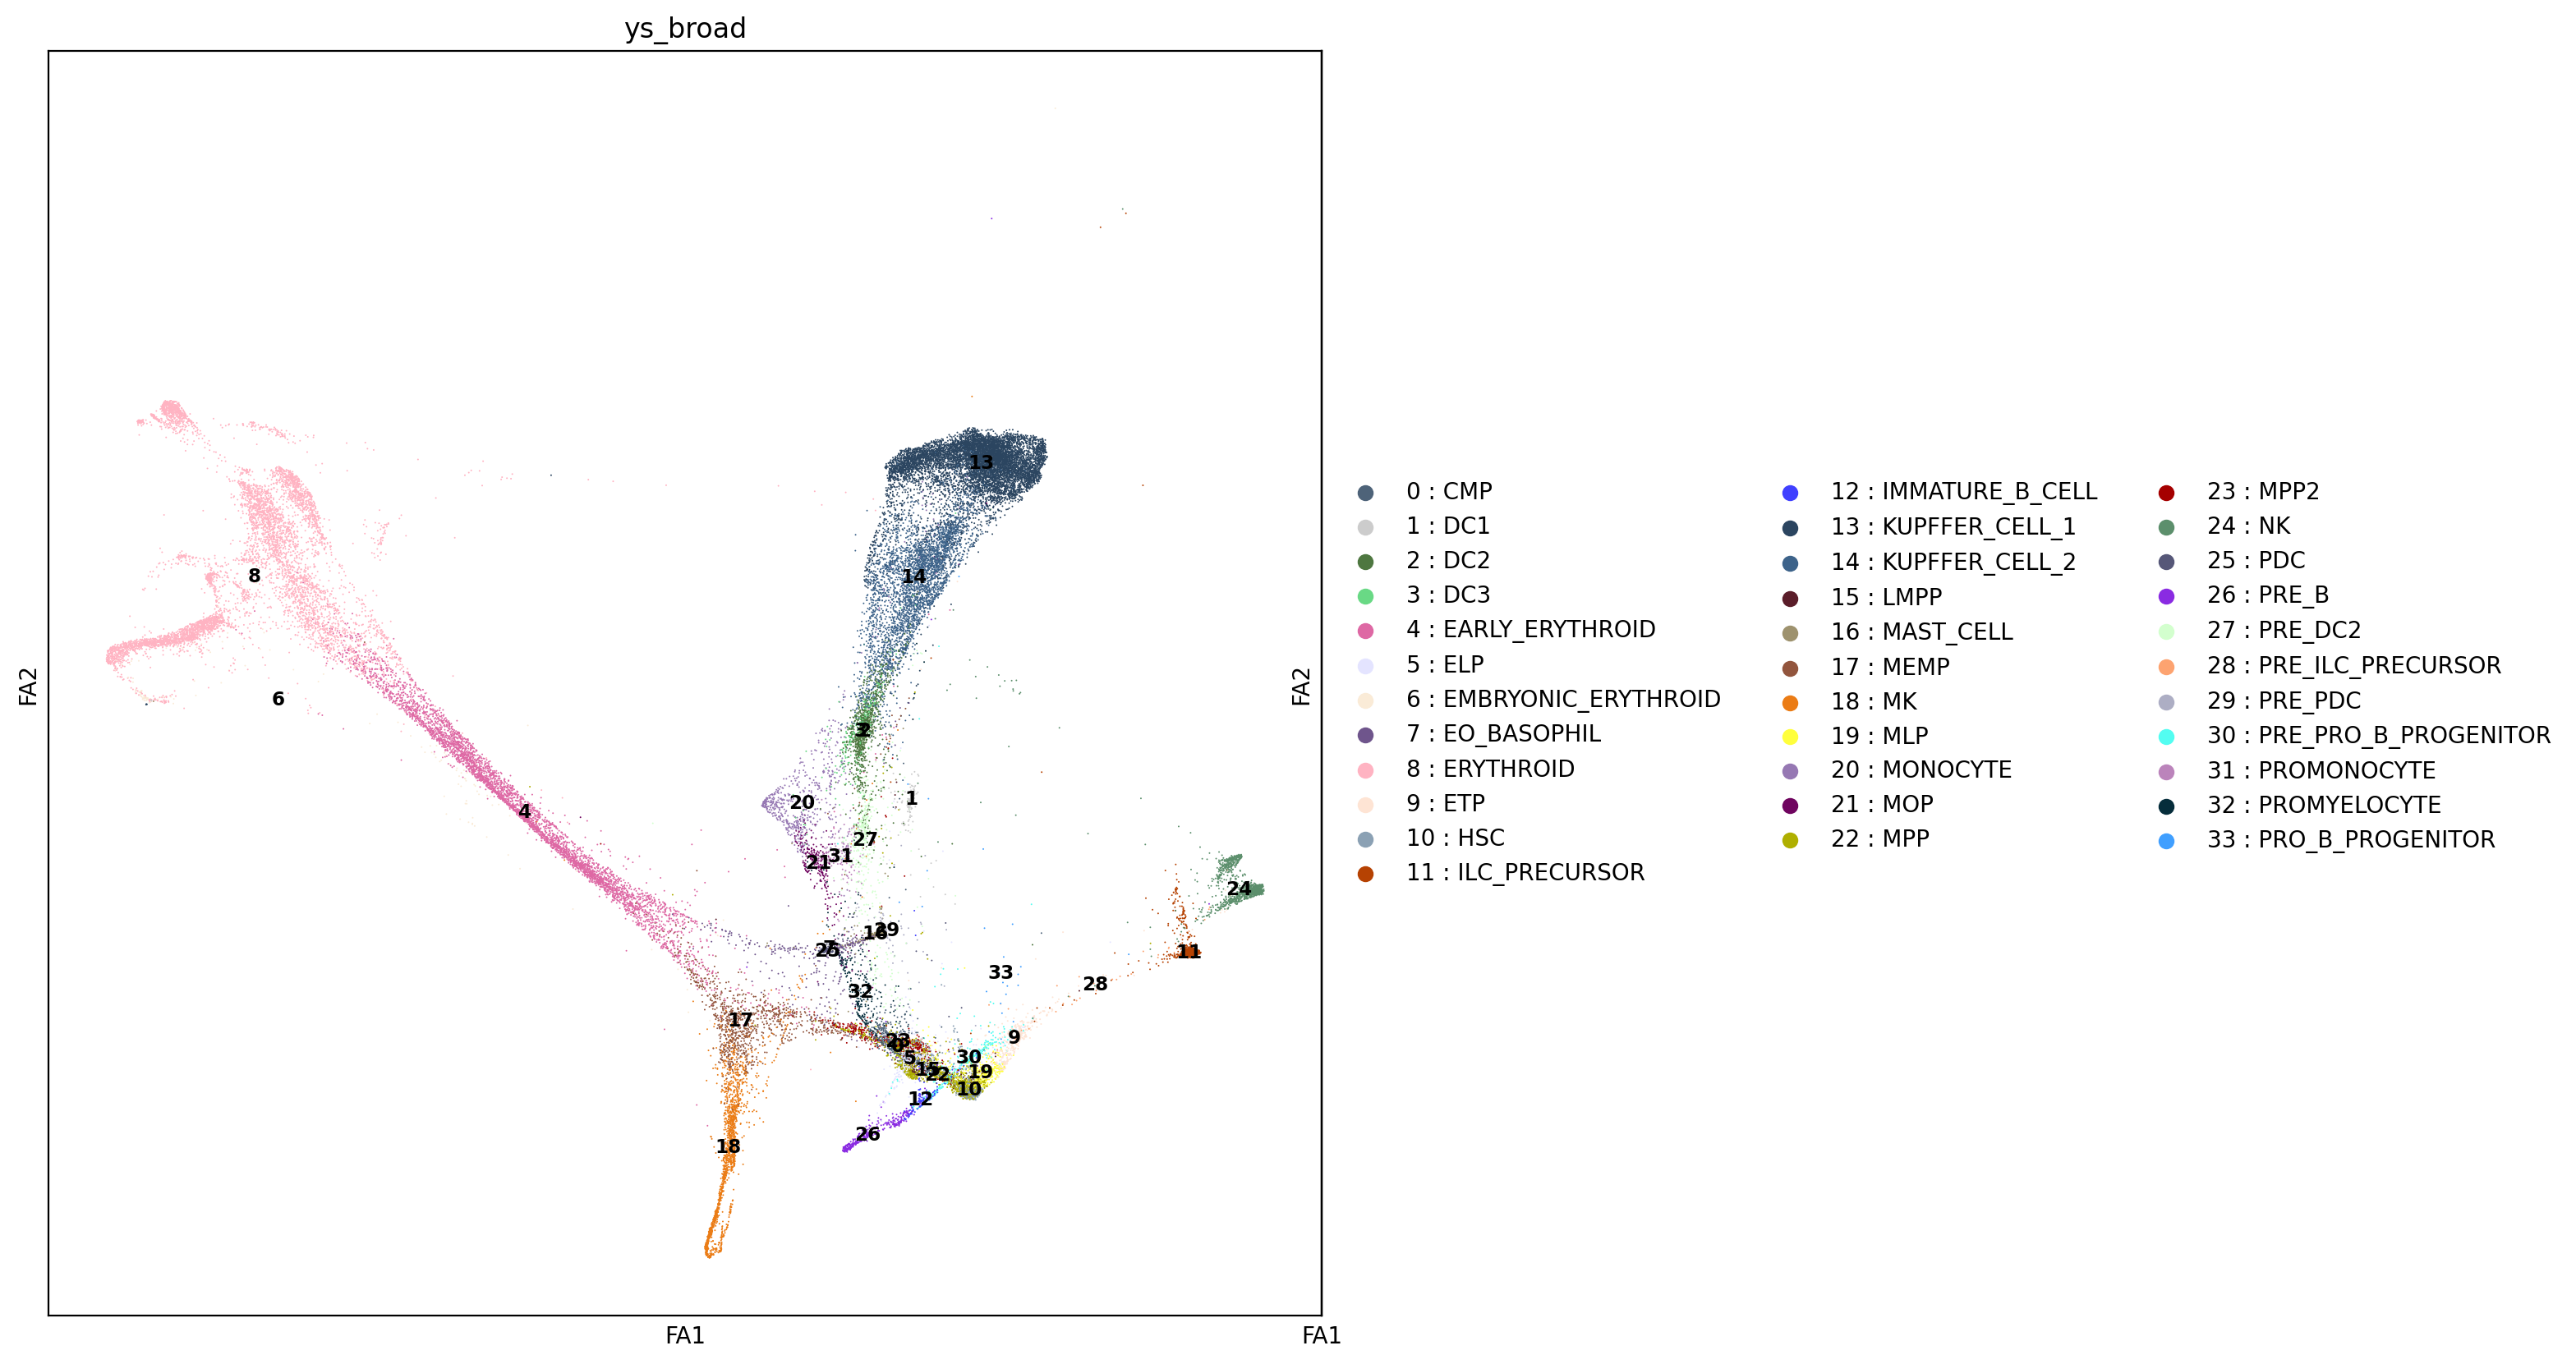

In [71]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.draw_graph(adata, color = (var+'_num') ,ax=ax2,show=False,size=5,title="", palette= col_pal) #title=i
p3 = sc.pl.draw_graph(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="ys_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"FLIV_HEAM_TRAJ_num.pdf",bbox_inches='tight')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'num' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'var_num' as categorical


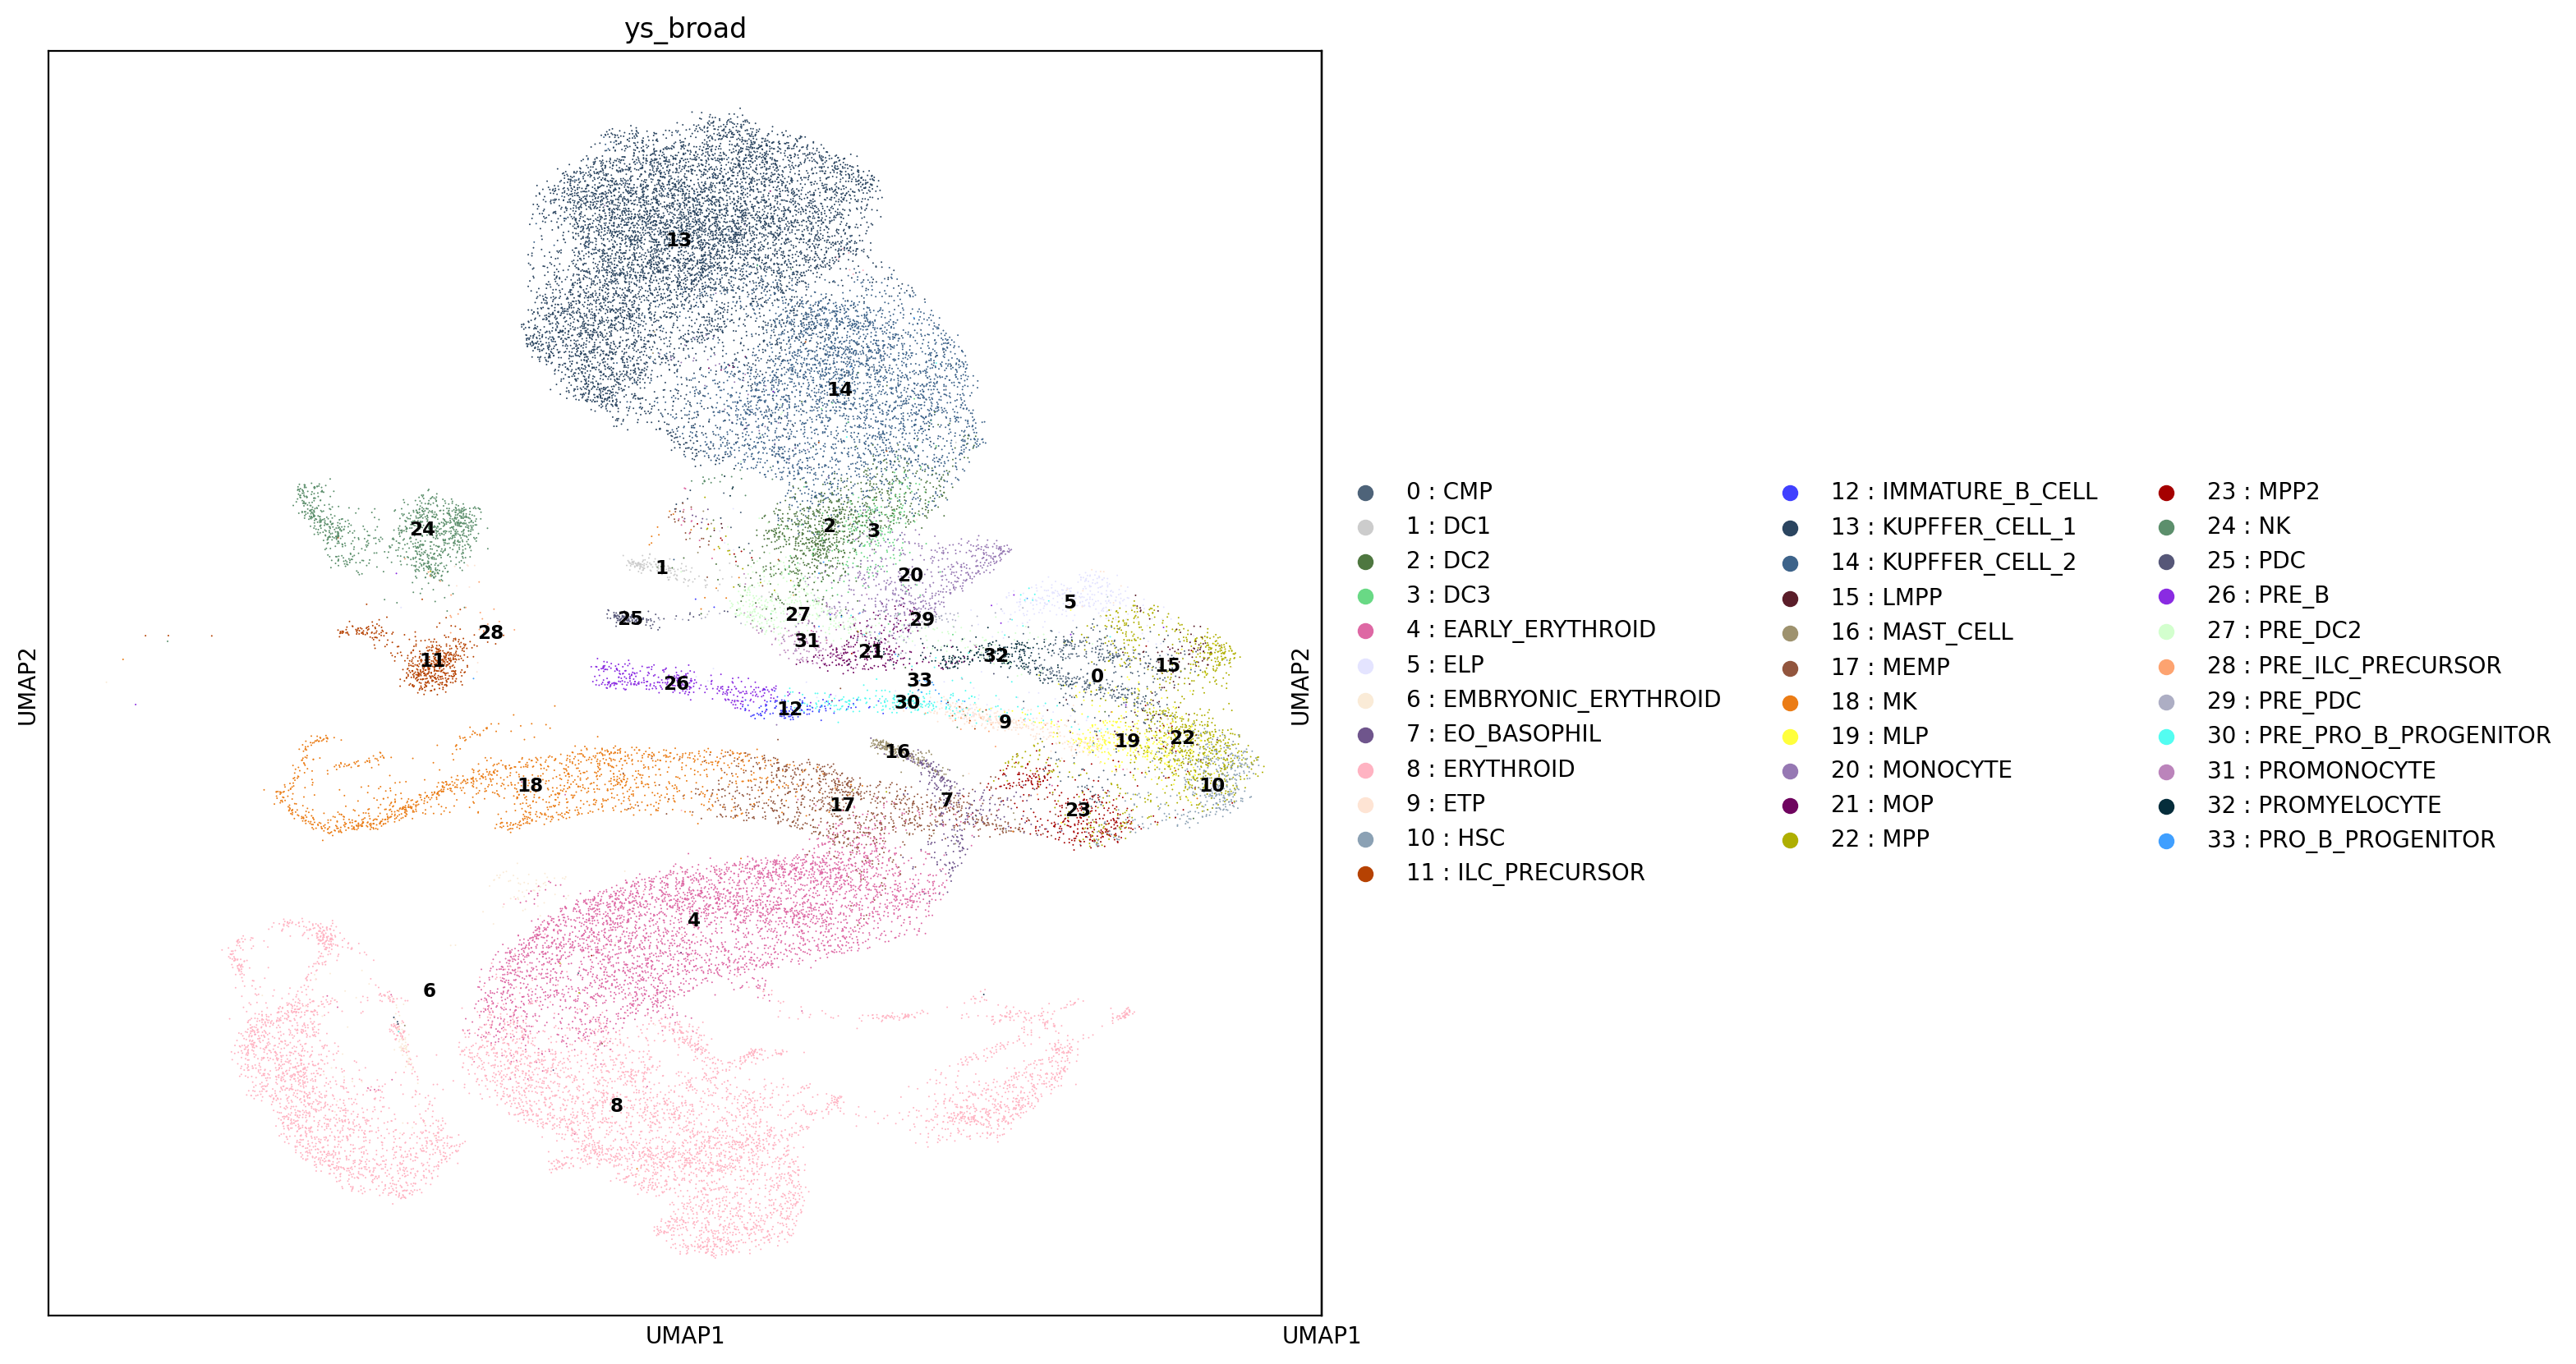

In [72]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,size=5,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="ys_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')

In [34]:
save_loc+run_name+'.h5ad'

'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/FLIV_Heam_trajectory_with_290921.h5ad'